<a href="https://colab.research.google.com/github/aryanchand227/Genetic-Algorithm-Image-Enhancement/blob/main/Iamge_Enchancemnt_Using_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image successfully loaded!


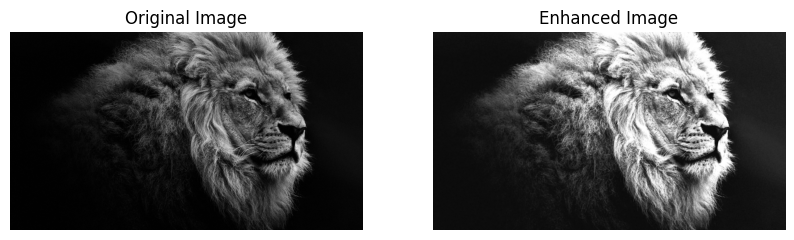

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import urllib.request
import requests
# Download image
image_url = "https://wallpaperaccess.com/full/1156126.jpg"
image_path = "/content/sample_image.png"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}
# Using requests library to download image, adding a User-Agent header
response = requests.get(image_url, headers=headers, stream=True)
response.raise_for_status()

with open(image_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

# Load image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if image is loaded
if image is None:
    raise ValueError("Image not loaded. Please check the image URL or upload the image.")
else:
    print("Image successfully loaded!")

# Define chromosome representation (brightness, contrast)
def initialize_population(population_size):
    # Adjusted ranges for brightness and contrast
    brightness = np.random.uniform(25, 150, population_size)  # Reduced upper bound for brightness
    contrast = np.random.uniform(0.5, 1.5, population_size)  # Reduced upper bound for contrast
    return np.stack([brightness, contrast], axis=1)

# Fitness evaluation: Mean squared error as a basic quality metric
def evaluate_fitness(population, target_image):
    fitness_scores = []
    for params in population:
        brightness, contrast = params
        adjusted_image = cv2.convertScaleAbs(target_image, alpha=contrast, beta=brightness)
        fitness = np.mean((adjusted_image - target_image) ** 2)
        fitness_scores.append(fitness)
    return fitness_scores

# Genetic algorithm operations (simplified)
def crossover(parents):
    return np.mean(parents, axis=0)

def mutate(chromosome, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        chromosome += np.random.randn(2) * 10  # Small random change
    return chromosome

def selection(population, fitness_scores, num_parents):
    # Tournament selection
    selected_indices = []
    for _ in range(num_parents):
        tournament_indices = np.random.choice(len(population), size=2, replace=False)
        tournament_fitness = [fitness_scores[i] for i in tournament_indices]
        winner_index = tournament_indices[np.argmin(tournament_fitness)]
        selected_indices.append(winner_index)
    return population[selected_indices]

# Initialize Population
population_size = 50
generations = 100
population = initialize_population(population_size)
mutation_rate = 0.1  # Initial mutation rate
best_parameters_list = []

# Genetic Algorithm Process
for generation in range(generations):
    fitness_scores = evaluate_fitness(population, image)
    selected_parents = selection(population, fitness_scores, population_size // 2)
    offspring = []
    for i in range(population_size // 2):
        parent_indices = np.random.choice(selected_parents.shape[0], size=2, replace=False)
        parents = selected_parents[parent_indices]
        child = crossover(parents)
        child = mutate(child, mutation_rate)
        offspring.append(child)
    population = np.vstack((selected_parents, offspring))
    mutation_rate *= 0.99  # Dynamic mutation rate adjustment

# Get best parameters and apply image enhancement
best_params = population[np.argmin(evaluate_fitness(population, image))]
brightness, contrast = best_params
best_parameters_list.append([brightness, contrast])

# Apply Image Enhancement
enhanced_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

# Clarity Enhancement using Unsharp Masking
gaussian_blurred = cv2.GaussianBlur(enhanced_image, (0, 0), 3)  # Adjust kernel size for desired blur
unsharp_mask = cv2.addWeighted(enhanced_image, 1.5, gaussian_blurred, -0.5, 0) # Adjust weights for clarity strength

# Noise Reduction using Bilateral Filter
denoised_image = cv2.bilateralFilter(unsharp_mask, 9, 75, 75)  # Adjust parameters for noise reduction strength

# Clip and convert to 8-bit for display
denoised_image = np.clip(denoised_image, 0, 255).astype(np.uint8)

# Display original and enhanced images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(denoised_image, cmap='gray')  # Display the denoised image
plt.axis('off')
plt.show()